This notebook includes :
1) Triggers reading
2) Events detection (begining / ending of a block, response of the subject etc.)
3) Plots (either per subject or at the population level)

In [35]:
import os
import json
import re
import glob

import numpy as np
import pandas as pd

# import matplotlib.pyplot as plt
# import seaborn as sns

import plotly
import plotly.express as px
plotly.__version__

'4.14.3'

---
# Global definitions
## Global variables

In [2]:
# defines where files are located
root = '/envau/work/bagamore/brovelli.a/Data/Neurophy/SEEG_EBRAINS/Cohort %s/%s/%s/*_MCSE_*.pos'
subject = 'HID-Sub-000'
sfreq = 64.

# load the cohort config file
with open("../../seeg-ebrains/config/db_cohort.json", 'r') as f:
    cfg = json.load(f)

## Global functions
### Read the triggers
Read the pos file and extract the triggers

In [3]:
def read_pos(path_pos):
    """Path to the pos file and return a dataframe containing the triggers and samples
    at which triggers appeared."""
    # read the file
    r = np.genfromtxt(path_pos)
    assert (r.ndim == 2) and (r.shape[1] == 3)
    # dataframe conversion
    df = pd.DataFrame(r[:, 0:2].astype(int), columns=['sample', 'trigger'])
    return df

### Event detection

In [4]:
def detect_events(df):
    """Detect events.
    
    This function takes as input the dataframe containing triggers and samples
    and return a dataframe which all of the detected events (easy /hard blocks;
    reponse; response time; correct / incorrect)
    """
    # detect consecutive events
    block, response, t_block = [], [], None
    for n_t, t in enumerate(list(df['trigger'])):
        if t in [11, 12, 61, 62]:
            t_block = n_t
        elif t in [1, 2] and t_block is not None:
            block += [t_block]
            response += [n_t]
            t_block = None
    # build dataframe
    dat = np.c_[df.loc[block, 'sample'], df.loc[response, 'sample'],
                df.loc[block, 'trigger'], df.loc[response, 'trigger']].astype(int)
    df_t = pd.DataFrame(dat, columns=['sample_stim', 'sample_resp', 'trig_stim', 'trig_resp'])
    # insert timings
    df_t['time_stim'] = df_t['sample_stim'] / sfreq
    df_t['time_resp'] = df_t['sample_resp'] / sfreq
    df_t['response_time'] = df_t['time_resp'] - df_t['time_stim']
    # add if correct answer
    df_t['correct'] = np.mod(dat[:, -2] - dat[:, -1], 10) == 0
    # add column for difficulty of the task
    df_t['difficulty'] = ['easy'] * len(df_t)
    stim = np.array(list(df_t['trig_stim']))
    df_t.loc[np.logical_or(stim == 61, stim == 62), 'difficulty'] = 'hard'
    # add orientation of the "T" letter
    df_t['T_orientation'] = ['T down'] * len(df_t)
    df_t.loc[np.logical_or(stim == 12, stim == 62), 'T_orientation'] = 'T up'
    return df_t


---
# Loading pos files and detect events

In [5]:
df_events, missing, fail = [], [], []
for coh in ['I', 'II', 'III']:
    suj_range = cfg[coh]['s_range']
    seeg_folder = cfg[coh]['seeg_folder']
    for suj in range(suj_range[0], suj_range[1] + 1):
        print(f"Cohort {coh} : {suj}", end='\r')
        # define subject name
        id_suj = str(suj)
        s_name = subject[0:-len(id_suj)] + id_suj
        
        # define path to the pos file
        path_pos = root % (coh, seeg_folder, s_name)
        
        # get pos file name
        file = glob.glob(path_pos)
        if len(file) != 1:
            missing += [suj]
            continue
        
        # read the triggers and events
        df_trig = read_pos(file[0])
        df_ev = detect_events(df_trig)
        
        # track those fow which events detection failed
        if len(df_ev) < 10:
            # here we say that if there's not at least, 10 events, it's considered
            # as a bad file
            fail += [suj]
            continue
        
        # add subject name to the columns
        df_ev['subject'] = [s_name] * len(df_ev)
        
        df_events += [df_ev]

print(f"Missing (total={len(missing)}) : {missing}")
print(f"Failed (total={len(fail)}) : {fail}")
df_events = pd.concat(df_events).reset_index()
n_subjects = len(np.unique(df_events['subject']))

Missing (total=2) : [28, 46]
Failed (total=35) : [6, 7, 34, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


In [ ]:
df_events

---
# Per subject results
## Mean response time between easy / hard blocks

In [14]:
gp_suj_dif = df_events.groupby(['subject', 'difficulty'])
df_resp_suj = gp_suj_dif.mean()['response_time'].reset_index()
# df_resp_suj

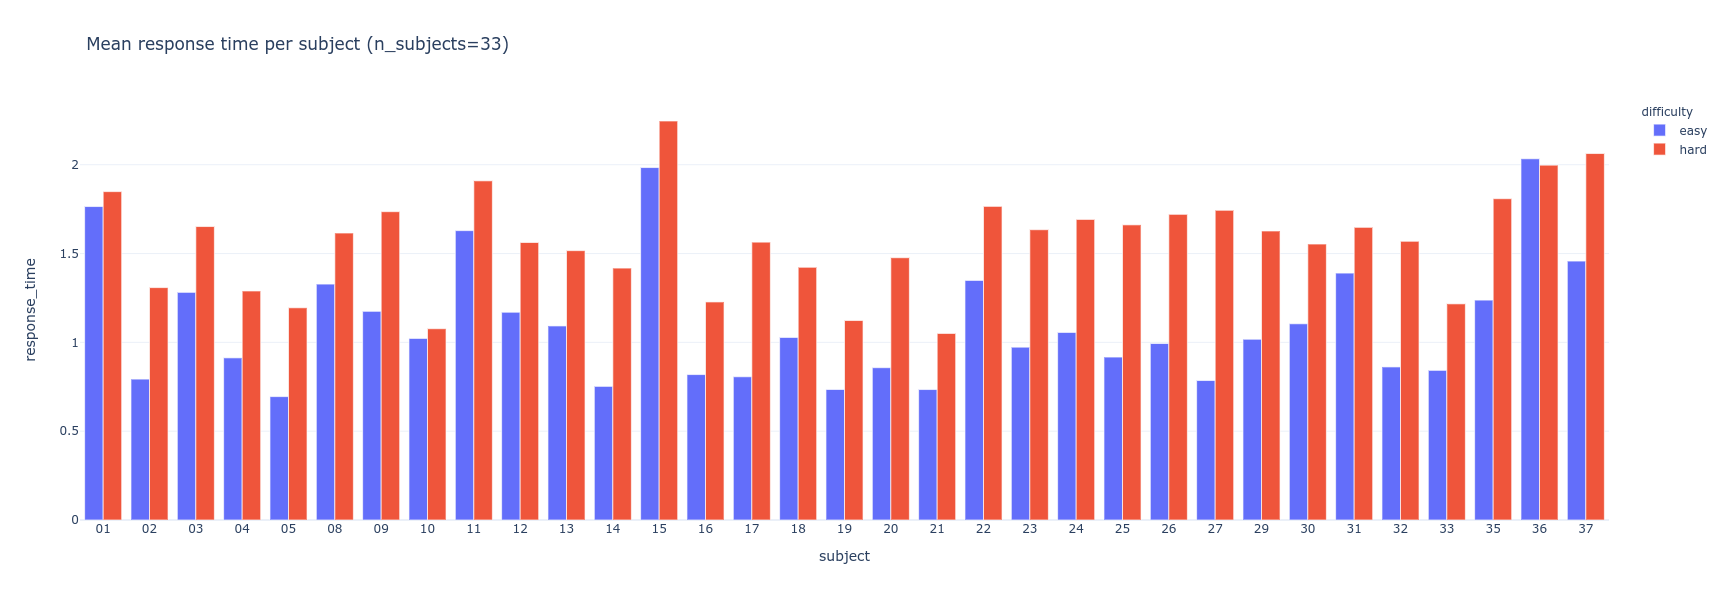

In [15]:
df_simple_suj = df_resp_suj.copy()
df_simple_suj.replace({'HID-Sub-0': ''}, inplace=True, regex=True)

px.bar(df_simple_suj, x='subject', y='response_time', color='difficulty', title=f'Mean response time per subject (n_subjects={n_subjects})',
       template='plotly_white', width=1400, height=600, barmode='group')

# Number of trials per subject and blocks

In [16]:
df_nb_trials = gp_suj_dif.count()['index'].reset_index().rename(columns={'index': '# trials'})

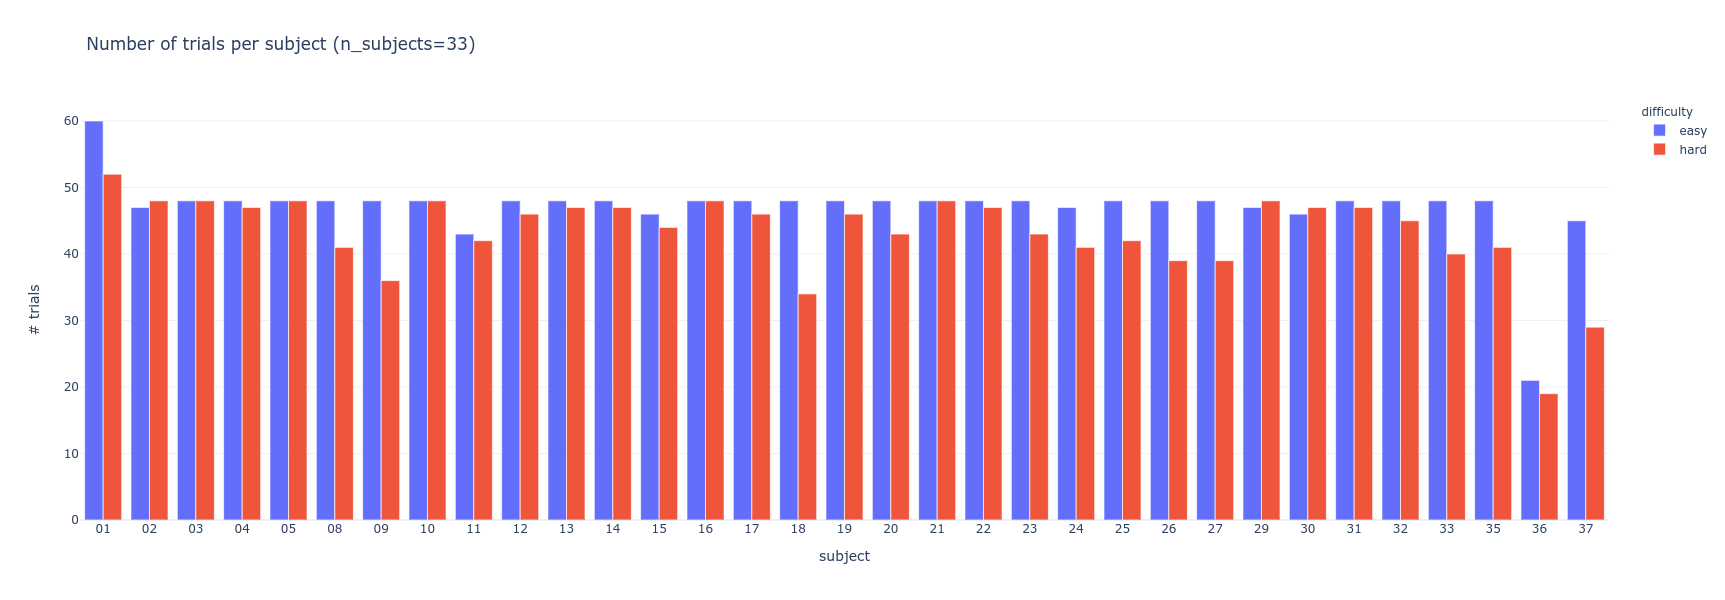

In [17]:
df_simple_trials = df_nb_trials.copy()
df_simple_trials.replace({'HID-Sub-0': ''}, inplace=True, regex=True)

px.bar(df_simple_trials, x='subject', y='# trials', color='difficulty', title=f'Number of trials per subject (n_subjects={n_subjects})',
       template='plotly_white', width=1400, height=600, barmode='group')

# Proportion of correct answers

In [18]:
def percent_correct(series):
    return 100 * series.sum() / len(series)

df_correct_prop = gp_suj_dif.agg({'correct': percent_correct}).reset_index().rename(columns={'correct': 'correct (%)'})
df_correct_prop

subject difficulty  correct (%)
0   HID-Sub-001       easy    26.666667
1   HID-Sub-001       hard    30.769231
2   HID-Sub-002       easy    97.872340
3   HID-Sub-002       hard    87.500000
4   HID-Sub-003       easy    97.916667
..          ...        ...          ...
61  HID-Sub-035       hard    82.926829
62  HID-Sub-036       easy    47.619048
63  HID-Sub-036       hard    57.894737
64  HID-Sub-037       easy    93.333333
65  HID-Sub-037       hard    89.655172

[66 rows x 3 columns]

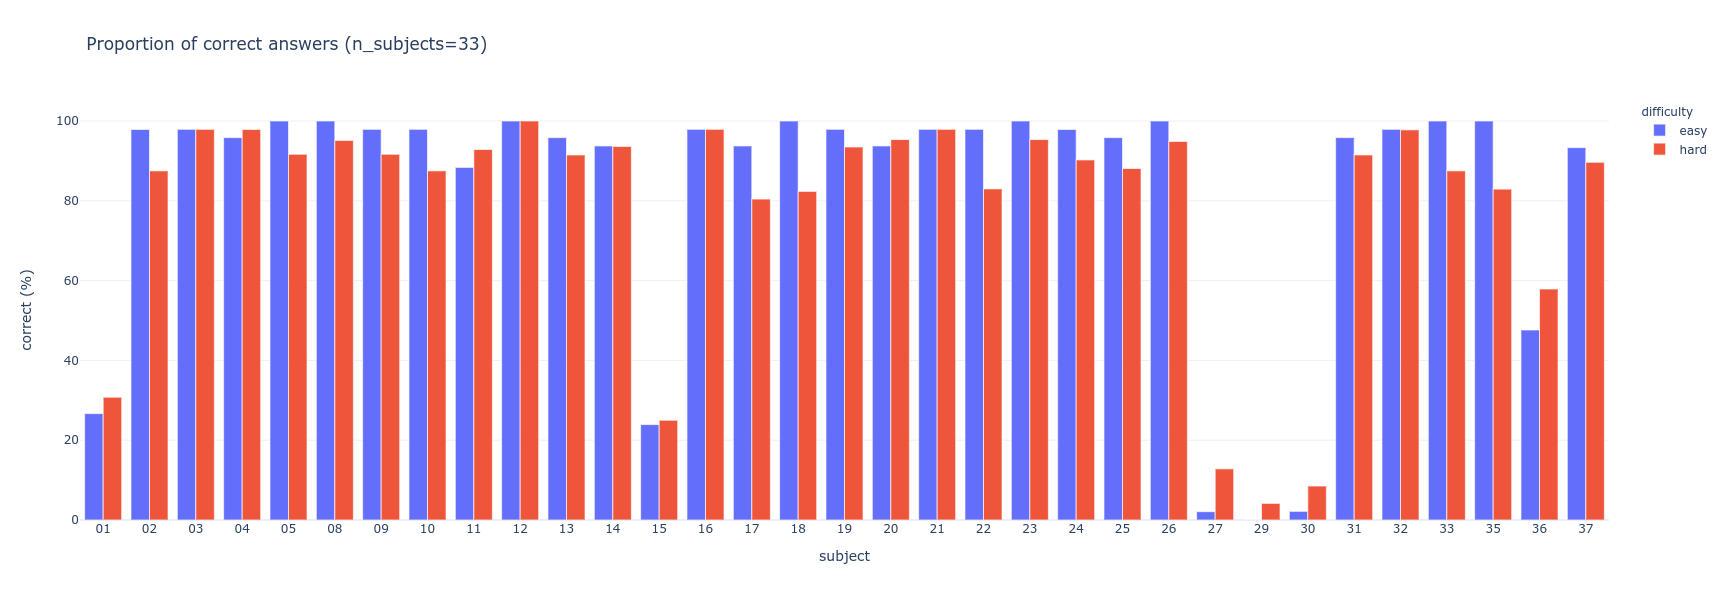

In [19]:
df_simple_prop = df_correct_prop.copy()
df_simple_prop.replace({'HID-Sub-0': ''}, inplace=True, regex=True)

px.bar(df_simple_prop, x='subject', y='correct (%)', color='difficulty', title=f'Proportion of correct answers (n_subjects={n_subjects})',
       template='plotly_white', width=1400, height=600, barmode='group')

---
# Results across population of subjects
## Distribution of response time

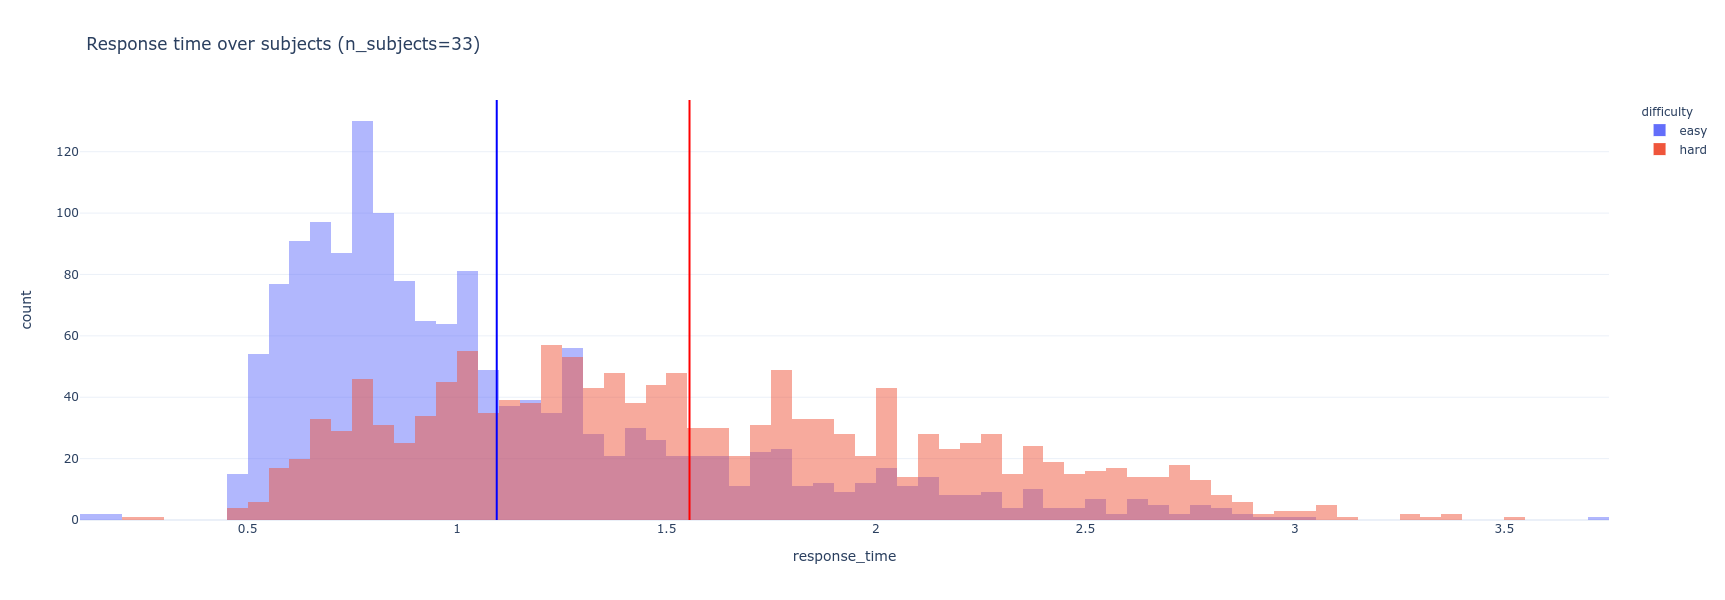

In [58]:
# group dataframe by difficulty
df_gp_diff = df_events.groupby('difficulty')

# Compute summary statistics
mean_resp_time = df_gp_diff.mean()['response_time']
std_resp_time = df_gp_diff.std()['response_time']
rep_easy = rf"$Easy = {np.round(mean_resp_time['easy'], 2)}s \pm {np.round(std_resp_time['easy'], 2)}$"
rep_hard = rf"$Hard = {np.round(mean_resp_time['hard'], 2)}s \pm {np.round(std_resp_time['hard'], 2)}$"

# plot the histograms
fig = px.histogram(df_events, x='response_time', color='difficulty', title=f'Response time over subjects (n_subjects={n_subjects})',
                   width=800, height=600, barmode='overlay', template='plotly_white')
fig.add_vline(x=mean_resp_time['easy'], annotation=dict(text=rep_easy, xanchor='right', xshift=-10, font=dict(color='blue', size=16)), line=dict(color='blue'))
fig.add_vline(x=mean_resp_time['hard'], annotation=dict(text=rep_hard, xanchor='left', xshift=10, font=dict(color='red', size=16)), line=dict(color='red'))

# if latex rendering don't work, try with offline rendering
# plotly.offline.plot(fig, include_mathjax='cdn')

fig

'temp-plot.html'